# HoG for Digit Recognition
(Taken and modified from the official tutorial of OpenCV on HoG)

In [0]:
import cv2
#import cv2.ml
import numpy as np
import itertools as it
import matplotlib.pyplot as plt


### Define some Helper Functions

In [0]:
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

# Load individual images from a bigger image (grid of small images)
def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

# De-skew the images by applying geometric transformations 
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

def grouper(n, iterable, fillvalue=None, PY3=True):
    '''grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx'''
    args = [iter(iterable)] * n
    if PY3:
        output = it.zip_longest(fillvalue=fillvalue, *args)
    else:
        output = it.izip_longest(fillvalue=fillvalue, *args)
    return output

# Make a grid if many small images
def make_grid_image(w, imgs, PY3=True):
    imgs = iter(imgs)
    if PY3:
        img0 = next(imgs)
    else:
        img0 = imgs.next()
    pad = np.zeros_like(img0)
    imgs = it.chain([img0], imgs)
    rows = grouper(w, imgs, pad)
    return np.vstack(map(np.hstack, rows))

# Create a SVM Model
def InitModel(C=12.5, gamma=0.50625):
  model = cv2.ml.SVM_create()
  model.setGamma(gamma)
  model.setC(C)
  model.setKernel(cv2.ml.SVM_RBF)
  model.setType(cv2.ml.SVM_C_SVC)
  return model

def Train(model, samples, responses):
  model.train(samples, cv2.ml.ROW_SAMPLE, responses)
  return model


#  Evaluate the model
def Evaluate(model, samples, labels):
    predictions = model.predict(samples)[1]
   
    count=0
    for pred, act in zip(predictions, labels):
        if pred==act:
           count=count+1

    accuracy = 100*(count/len(labels))
    print('\n Percentage Accuracy: %.2f %%' % (accuracy))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, predictions):
        confusion[int(i), int(j)] += 1
    print('\n Confusion Matrix:')
    print(confusion)

    return



# Reshaping and normalizing the pixels
def preprocess(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0

# Get HoG feature descriptor object
def get_hog_features(): 
    winSize = (20,20)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog


In [0]:
# individual digit sizes
SZ = 20
# Number of classes - 0 to 9 total 10 classes
CLASS_N = 10


### Input the Image Containing all Subimages

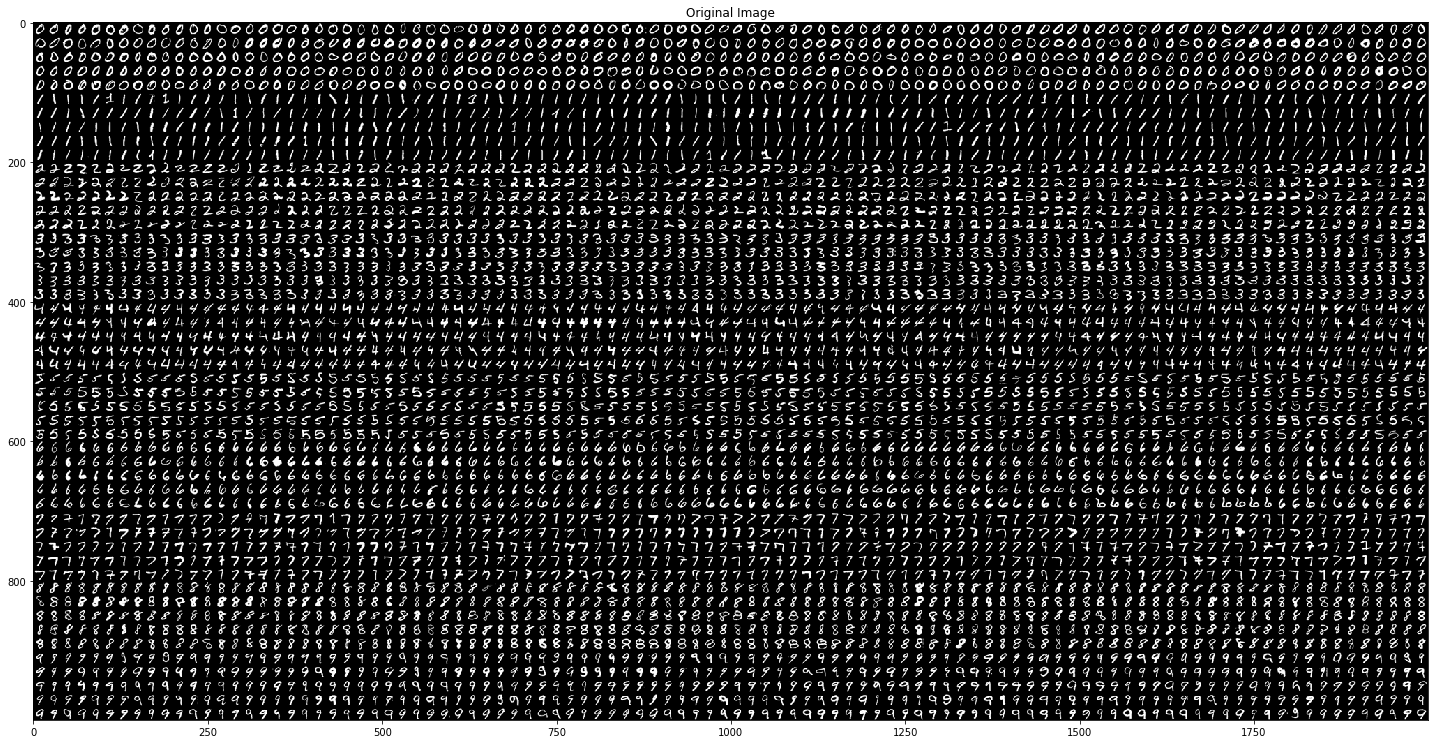

In [100]:
img= cv2.imread('digits.png')
plt.figure(figsize=(25,35))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

### Load the Original Bigger Image and Split the Smaller images of the digits from it

In [101]:
print('Loading digits from digits.png ... ')

# Load data.
digits, labels = load_digits('digits.png')

print('Shuffle data ... ')

# Shuffle data - change the order of the images
rand = np.random.RandomState(10)
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]
    


Loading digits from digits.png ... 
Shuffle data ... 


### Apply skew-correction to the individual digit images

In [102]:
print('Deskewed images ... ')
digits_deskewed = list(map(deskew, digits))
    

Deskewed images ... 


### Define the HoG Object from OpenCV and compute HoG Features Descriptors

In [103]:
print('Defining HoG parameters ...')

# HoG feature descriptor
hog = get_hog_features();

print('Calculating HoG descriptor for every image ... ')

hog_descriptors = []

for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
    
hog_descriptors = np.squeeze(hog_descriptors)


Defining HoG parameters ...
Calculating HoG descriptor for every image ... 


### Split Data Into Training and Test Set

In [104]:
print('\n Splitting data into training (90%) and test set (10%)... ')
train_n=int(0.9*len(hog_descriptors))

digits_train, digits_test = np.split(digits_deskewed, [train_n])

# Training and Testing Images
hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])

# Training and Testing Digit Labels
labels_train, labels_test = np.split(labels, [train_n])


 Splitting data into training (90%) and test set (10%)... 


### Train a Machine Learning Model - Support Vector Machine on the Training Data

In [105]:
# Create a ML object - SVM in this case  
model = InitModel()

print('\n Training SVM Model on Training Data...')
Train(model, hog_descriptors_train, labels_train)



 Training SVM Model on Training Data...


<ml_SVM 0x7fdef912d4b0>

### Test the Model on Test Data

The confusion matrix shows the number of correct and incorrect predictions of the SVM model on the Test data.

All the off-diagonal entries are the mis-classifications.

In [106]:
print('\n Evaluating the Model ... ')
Evaluate(model, hog_descriptors_test, labels_test)



 Evaluating the Model ... 

 Percentage Accuracy: 99.00 %

 Confusion Matrix:
[[52  0  0  0  0  0  0  0  0  0]
 [ 0 43  2  0  0  0  0  0  0  0]
 [ 0  0 61  0  0  0  0  1  0  0]
 [ 0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 50  1  0]
 [ 0  0  0  0  0  1  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 51]]
